In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore',category=UserWarning)
import time
import pickle
import re
import sys
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import subprocess
import string
import itertools
import multiprocessing

In [2]:
import pickle
import argparse
import re
import numpy as np
import pandas as pd
import tqdm

In [174]:
class CFD_calculator:
    def __init__(self, wt, off, DNA_bulge = False):
        
        if not DNA_bulge:
            pam = off[-2:]
            sg = off[:-3]
            self.cfd_score = self.calc_cfd(wt, sg, pam)
        else:
            wt = wt[1:]
            off = off[1:-3]
            pam = off[-2:]
            self.cfd_score = self.calc_cfd(wt, off, pam)

    # Reverse complements a given string
    def revcom(self, s):
        basecomp = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'U': 'A', '-':'-'}
        letters = list(s[::-1])
        try:
            letters = [basecomp[base] for base in letters]
        except:
            return None
        return ''.join(letters)


    # Unpickle mismatch scores and PAM scores
    def get_mm_pam_scores(self):
        try:
            mm_scores = pickle.load(open('./mismatch_score.pkl', 'rb'))
            pam_scores = pickle.load(open('./PAM_scores.pkl', 'rb'))
            return mm_scores, pam_scores
        except:
            raise Exception("Could not find file with mismatch scores or PAM scores")


    # Calculates CFD score
    def calc_cfd(self, wt, off, pam):
        mm_scores, pam_scores = self.get_mm_pam_scores()    
        score = 1
        wt = wt.replace('T', 'U')
        off = off.replace('T', 'U')
        s_list = list(off)
        guide_seq_list = list(wt)
        for i, sl in enumerate(s_list):
            if guide_seq_list[i] == sl:
                score *= 1
            else:
                try:    #Catch exception if IUPAC character
                    key = 'r' + guide_seq_list[i] + ':d' + self.revcom(sl) + ',' + str(i + 1)
                except Exception as e:
                    score = 0
                    break
                try:
                    score *= mm_scores[key]
                    # print(i, key, mm_scores[key])
                except Exception as e : #If '-' is in first position, i do not have the score for that position
                    pass
        try:
            score *= pam_scores[pam]
        except:
            score *= 1
            print(wt, off, pam, 'no such PAM')
            return -1
        return score


In [121]:
HEK4_df = pd.read_csv("../HEK4_WGS/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.out", "\t")
HEK4_df['CFDscore'] = None

In [162]:
cfd_scores = []
for idx, row in tqdm.tqdm(HEK4_df.iterrows()):
    wt = row['crRNA'].upper()
    off = row['DNA'].upper()
    if row['#Bulge type'] == 'DNA':
        cfd = CFD_calculator(wt, off, DNA_bulge=True)
    else:
        cfd = CFD_calculator(wt, off, DNA_bulge=False)
    if cfd.cfd_score < 0:
        print(idx, wt, off)
        cfd_scores.append(0)
    else:    
        cfd_scores.append(cfd.cfd_score)
HEK4_df['CFDscore'] = cfd_scores

325339it [02:31, 2175.71it/s]

GGCACUGCGGCUGGAGGUGGNNN GACA-UCCGGCUGU      
325072 GGCACTGCGGCTGGAGGTGGNNN GACA-TCCGGCTGT      


338668it [02:37, 2183.28it/s]

GCACUGCGGC-UGGAGGUGGNNN GAAUUC  C 
338385 GGCACTGCGGC-TGGAGGTGGNNN GGAATTC    


359468it [02:47, 2145.15it/s]


In [163]:
HEK4_df.to_csv("../HEK4_WGS/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.CFDscore.out", index_label='target_name', sep="\t")

In [5]:
HEK4_df = pd.read_csv("../HEK4_WGS/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.CFDscore.out", "\t")

In [9]:
HEK4_df[HEK4_df['#Bulge type'] == 'DNA']

,target_name,#Bulge type,crRNA,DNA,Chromosome,Position,Direction,Mismatches,Bulge Size,Location,GUIDE-Seq,CFDscore
533,533,DNA,G-GCACTGCGGCTGGAGGTGGNNN,GGGCACTGCcGCTGcAGGcGcAGG,chr1,15370,+,4,1,chr1:15370+,0,0.000942
534,534,DNA,G-GCACTGCGGCTGGAGGTGGNNN,GAGCcCTGCtGCTtGcGGTGGCCT,chr1,12851,+,4,1,chr1:12851+,0,0.015401
535,535,DNA,G-GCACTGCGGCTGGAGGTGGNNN,GAGCcCTGCtGCTtGcGGTGGCCT,chr1,183370,+,4,1,chr1:183370+,0,0.015401
536,536,DNA,G-GCACTGCGGCTGGAGGTGGNNN,GGGCACTGCcGCTGcAGGcGcAGG,chr1,185891,+,4,1,chr1:185891+,0,0.000942
537,537,DNA,G-GCACTGCGGCTGGAGGTGGNNN,GGGagCTGgGGCTGGAGGTGtGGA,chr1,402707,+,4,1,chr1:402707+,0,0.003931
...,...,...,...,...,...,...,...,...,...,...,...,...
357994,357994,DNA,GGCACTGCGGCTGGAGGTG-GNNN,cGCcCTGtGGCTGGAGGcGAGTTA,chrY,25418808,-,4,1,chrY:25418808-,0,0.019608
357995,357995,DNA,GGCACTGCGGCTGGAGGTG-GNNN,GGCcCTGgtGCTGGAGGTGTtGGT,chrY,25481346,+,4,1,chrY:25481346+,0,0.000000
357996,357996,DNA,GGCACTGCGGCTGGAGGTG-GNNN,GGCAgcGaGGCTGGAGGaGGGGCG,chrY,25965029,-,4,1,chrY:25965029-,0,0.007143
357997,357997,DNA,GGCACTGCGGCTGGAGGTG-GNNN,GGCAgcGaGGCTGGAGGaGAGGCG,chrY,57122922,-,4,1,chrY:57122922-,0,0.015954


In [145]:
# GGCACTGCGGCTGGAGGTGGNNN	GGCAgcGaGGCTGGAGGa-GAGG
wt = 'GGCACTGCGGCTGGAGGTGGNNN'.upper()
off = 'GGCACTGCcGCTGcAGGcGcAGG'.upper()
cfd = CFD_calculator(wt, off, DNA_bulge=False)
cfd.cfd_score

0.04238618533415564

In [166]:
result_df = pd.read_csv("../HEK4_WGS/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.csv", index_col='target_name')
casoff_df = pd.read_csv("../HEK4_WGS/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.CFDscore.out", "\t")
pad_df = pd.read_csv("../HEK4_WGS/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.out.pad42.txt", "\t")

In [167]:
casoff_df['target_name'] = pad_df['#Bulge typeBulge SizeMismatches_0']
casoff_df = casoff_df.set_index('target_name')
result_df = pd.read_csv("../HEK4_WGS/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.csv", index_col='target_name')
result_df['CFD_score'] = casoff_df.loc[result_df.index,'CFDscore']

In [168]:
result_df.to_csv("../HEK4_WGS/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.CFD.csv", index_label='target_name')

# RNF2_df

In [206]:
RNF2_gap0 = pd.read_csv("../RNF2_WGS/RNF2.GTCATCTTAGTCATTACCTG.gap0.offby4.NNN.CasOffinder.out.pad42.txt.pam.CFD.txt", "\t", index_col='#Bulge typeBulge SizeMismatches_0')
RNF2_gap1 = pd.read_csv("../RNF2_WGS/RNF2.GTCATCTTAGTCATTACCTG.gap1.offby4.NNN.CasOffinder.out.pad42.txt.pam.txt", "\t", index_col='#Bulge typeBulge SizeMismatches_0')

In [207]:
cfd_scores = []
for idx, row in tqdm.tqdm(RNF2_gap1.iterrows()):
    wt = row['crRNA'].upper()
    off = row['DNA'].upper()
    if row['#Bulge type'] == 'DNA':
        cfd = CFD_calculator(wt, off, DNA_bulge=True)
    else:
        cfd = CFD_calculator(wt, off, DNA_bulge=False)
    if cfd.cfd_score < 0:
        print(idx, wt, off)
        cfd_scores.append(0)
    else:    
        cfd_scores.append(cfd.cfd_score)
RNF2_gap1['CFD_score'] = cfd_scores

205782it [01:43, 1995.15it/s]


In [208]:
gap_up1 = pd.concat((RNF2_gap0, RNF2_gap1))

In [195]:
RNF2_gap1 = RNF2_gap1.set_index('#Bulge typeBulge SizeMismatches_0')

In [214]:
RNF2_df = pd.read_csv("../RNF2_WGS/RNF2.4mm.up1gap.GOOD.targetsite.wgsResult.csv", index_col='target_name')
RNF2_df['CFD_score'] = None

/data/pinello/SHARED_SOFTWARE/anaconda3/envs/lin_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [215]:
RNF2_df.loc[RNF2_df.index, 'CFD_score'] = gap_up1.loc[RNF2_df.index, 'CFD_score']

In [218]:
RNF2_df.to_csv("../RNF2_WGS/RNF2.4mm.up1gap.GOOD.targetsite.wgsResult.CFD.csv")

In [217]:
RNF2_df

,chr_id,bpstart,bpend,target_seq,n_reads,cutting_rate_Treated,sum_indel_reads_Treated,sum_reads_Treated,#indels_Treated,correlationS_Treated,...,sum_indel_reads_Control,sum_reads_Control,#indels_Control,correlationS_Control,correlationK_Control,delta_correlationK,delta_correlationS,delta_cutting_rate,withControl,CFD_score
target_name,,,,,,,,,,,,,,,,,,,,,
X04_1,chr1,48256,48341,TGCCATATTTGATAAAGCATTTGATAATCTTAGTCAATGCCTGGGC...,759,0.0,0.0,759.0,0.0,0.0,...,0.0,800.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.002063
X04_2,chr1,5070363,5070448,TATACAAAGATGCCAATTAATTTTGAGCCTTCACTTCCAGGTACTG...,751,0.0,0.0,751.0,0.0,0.0,...,0.0,752.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000
X04_3,chr1,5293710,5293795,TCTCTGGTCTGGACTTGCCCAGTCTCTTCTGAGTCATTCCCTGGCC...,818,0.0,0.0,818.0,0.0,0.0,...,0.0,739.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000
X04_4,chr1,6453418,6453503,CCTTATACGTGGGCTGGGGGGCGTGTTAGGGAAGGAGGAGGTGATG...,878,0.0,0.0,878.0,0.0,0.0,...,0.0,857.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000
X04_5,chr1,7809773,7809858,CCTAATTTAGTATTTCAGGAATTGTCATCTTAATTTTTACATGATT...,599,0.0,0.0,599.0,0.0,0.0,...,0.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RNA14_203967,chrX,155334396,155334481,ACTTGAGTGCCGGGCCGCAGGCCTGACATCTTTGTCTTTACTGCCA...,783,0.0,0.0,783.0,0.0,0.0,...,0.0,853.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.000000
RNA14_203968,chrX,155383702,155383787,TCCGCACGGTACGTCTTCATGGGAGTCATTTTATTCCTTACAGCTT...,500,0.0,0.0,500.0,0.0,0.0,...,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.000000
RNA14_203969,chrX,155456928,155457013,GCTTTATCATGGATTTAGGGCTGTGGTTACAAGGAAGCTGTAAGGA...,539,0.0,0.0,539.0,0.0,0.0,...,0.0,507.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.000000


In [157]:
import matplotlib
import seaborn as sns;
import matplotlib.pylab as plt
%matplotlib notebook
sns.set()
# sns.set_context('poster')
sns.set_style('white')

<IPython.core.display.Javascript object>


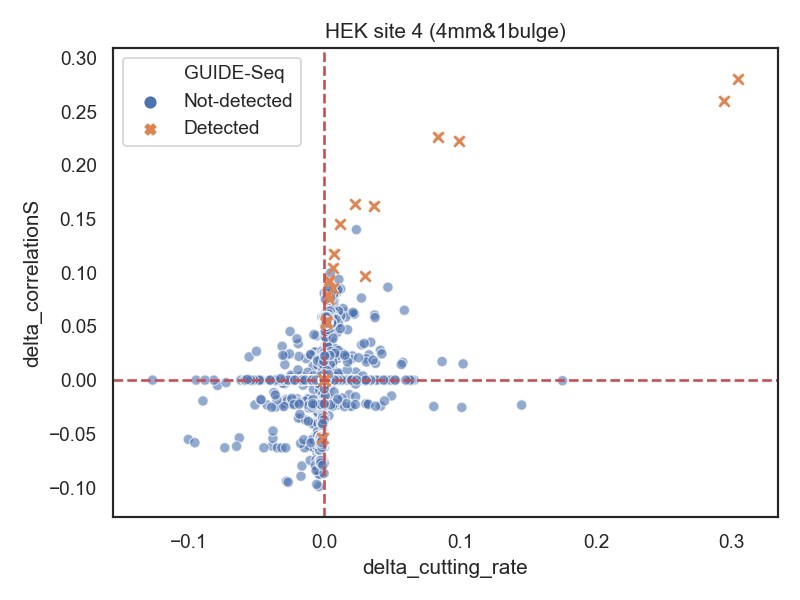

In [96]:
valid_VEGFA3_df = result_df
# filtered_df = valid_VEGFA3_df[((1.0*valid_VEGFA3_df['sum_indel_reads_Treated']/valid_VEGFA3_df['sum_reads_Treated']) - (1.0*valid_VEGFA3_df['sum_indel_reads_Control']/valid_VEGFA3_df['sum_reads_Control']))>0]
filtered_df = valid_VEGFA3_df# [valid_VEGFA3_df['sum_indel_reads_Treated']>0]
active_df = filtered_df[filtered_df['GUIDE-Seq'] == 'Detected']
# filtering based on the indels number of each allels
# filtered_df = filtered_df[filtered_df['#Reads_correlation'] == 0.0]
# filtered_df = filtered_df[(filtered_df['sum_reads_Treated'] > 200)&(filtered_df['sum_reads_Control'] > 200)]
edit_rate = filtered_df['delta_cutting_rate']
corr = filtered_df['delta_correlationS']
# ax = sns.scatterplot(x=edit_rate, y=corr, alpha=0.8)
val = filtered_df['GUIDE-Seq']
# active_df = pd.read_csv("../offBy4/guideseq/CRISPRessoWGS.VEGFA3.guideseq.targetsite.WGSresults.CFD.csv",)
# active_df = active_df[(1.0*active_df['sum_indel_reads_Treated']/active_df['sum_reads_Treated']-1.0*active_df['sum_indel_reads_Control']/active_df['sum_reads_Control'])>0]
ax = sns.scatterplot(x=edit_rate, y=corr, hue=val, style=val, alpha=0.6,style_order=['Not-detected', 'Detected'], hue_order=['Not-detected', 'Detected'])
# plt.scatter(filtered_df['delta_cutting_rate'], filtered_df['delta_correlationS'], c='b', marker ='o', alpha=0.6)
plt.scatter(active_df['delta_cutting_rate'], active_df['delta_correlationS'], marker='x')
# plt.scatter(filtered_df['delta_cutting_rate'], filtered_df['delta_correlationS'], c='b', marker ='o', alpha=0.6)
# plt.scatter(active_df['CFD_score'], active_df['delta_correlationS'], marker='x')
ax.axhline(0, ls='--', color='r')
ax.axvline(0, ls='--', color='r')
plt.title("HEK site 4 (4mm&1bulge)")
# plt.xlabel('Editing % (treated-control)')
# plt.ylabel('inDelphi Correlation (treated-control)')
# plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('VEGFA3_offby6.png', dpi=600)
plt.show()

In [219]:
VEGFA3_nafiz = pd.read_csv("../forNafiz/VEGFA3.6mm.0gap.WGS.Nafiz.csv")